In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from models.Clustering import Clustering

plt.style.use('ggplot')

In [4]:
inputs_path = os.path.join(os.getcwd(), "data", "inputs")
forecast_input = "wrds_etf_returns"
memory_input = "fredmd_transf"

## Load memory data - FREDMD

In [5]:
# load memory data and preprocess
memory_data = pd.read_csv(os.path.join(inputs_path, f'{memory_input}.csv'))

## fix dates
memory_data["date"] = pd.to_datetime(memory_data["date"])
memory_data = memory_data.set_index("date")
memory_data = memory_data.astype(float)

# fill missing values
memory_data = memory_data.interpolate(method='linear', limit_direction='forward', axis=0)
memory_data = memory_data.ffill()
memory_data = memory_data.bfill()

## compute moving average
memory_data = memory_data.rolling(window=12).mean()

## drop missing values
memory_data = memory_data.dropna()

## Run Kmeans with euclidean + cosine distances as the input of each pass

In [9]:
clustering_method = 'kmeans'
k_opt_method = 'elbow'
k = 5

low_pass_clustering = Clustering(similarity_method='euclidean')
clustering = Clustering(similarity_method='cosine')

# subset train data
train = memory_data.copy()

# compute clusters for easy days
low_pass_k = 2
cutoff_date = pd.Timestamp('2021-06-01')
#cutoff_date = pd.Timestamp('2021-11-01')
if train.index.to_list()[-1] > cutoff_date:
    low_pass_k = 3
knn_clusters, knn_euc_clusters, knn_euc_probs = low_pass_clustering.compute_clusters(data=train, extra_data=train, method=clustering_method, k=low_pass_k, k_opt_method=k_opt_method)

# find the cluster with the most observations and set as "hard days"
train["cluster"] = knn_clusters
cluster_sizes = []
for i in range(low_pass_k):
    temp = train.loc[:, "cluster"] == i
    temp = temp[temp == True]
    cluster_sizes.append(len(temp))
knn_largest_cluster = np.argmax(cluster_sizes)

## subset train data
knn_train_hard = train[train.loc[:, "cluster"] == knn_largest_cluster].copy()
knn_train_easy = train[train.loc[:, "cluster"] != knn_largest_cluster].copy()
temp = []
for i in range(low_pass_k):
    if i == knn_largest_cluster:
        temp.insert(0, knn_euc_clusters[i])
    else:
        temp.append(knn_euc_clusters[i])
knn_euc_clusters = np.array(temp)
knn_euc_probs = np.concatenate([knn_euc_probs[:, knn_largest_cluster].reshape(-1, 1), np.delete(knn_euc_probs, knn_largest_cluster, axis=1)], axis=1)

# compute clusters for hard days
knn_clusters, knn_hard_centroids, knn_hard_probs = clustering.compute_clusters(data=knn_train_hard, extra_data=train, method=clustering_method, k=k)

knn_train_easy["cluster"] = 0
knn_train_hard["cluster"] = knn_clusters + 1
# merge easy and hard clusters
knn_train = pd.concat([knn_train_easy, knn_train_hard]).sort_index()

In [10]:
knn_euc_probs

array([[0.46385864, 0.41216055, 0.12398081],
       [0.42755372, 0.45096877, 0.12147751],
       [0.42508873, 0.45349894, 0.12141232],
       ...,
       [0.42928801, 0.44933884, 0.12137315],
       [0.43370176, 0.44480529, 0.12149295],
       [0.48594002, 0.38789072, 0.12616926]])

In [11]:
knn_hard_probs

array([[0.15535932, 0.24212851, 0.20667485, 0.18087004, 0.21496728],
       [0.18443475, 0.20802147, 0.19425441, 0.18708862, 0.22620074],
       [0.18543063, 0.20754239, 0.19438072, 0.18765068, 0.22499558],
       ...,
       [0.18231377, 0.20903608, 0.19399   , 0.1859009 , 0.22875924],
       [0.17995952, 0.21016025, 0.19373157, 0.18461827, 0.23153039],
       [0.18265403, 0.19910445, 0.23874779, 0.22558269, 0.15391104]])

## Run GMM in Kmeans place

In [13]:
clustering_method = 'gmm'
k_opt_method = 'elbow'
k = 5

low_pass_clustering = Clustering(similarity_method='euclidean')
clustering = Clustering(similarity_method='cosine')

# subset train data
train = memory_data.copy()

# compute clusters for easy days
low_pass_k = 2
cutoff_date = pd.Timestamp('2021-06-01')
#cutoff_date = pd.Timestamp('2021-11-01')
if train.index.to_list()[-1] > cutoff_date:
    low_pass_k = 3
gmm_clusters, gmm_euc_clusters, gmm_euc_probs = low_pass_clustering.compute_clusters(data=train, extra_data=train, method=clustering_method, k=low_pass_k, k_opt_method=k_opt_method)

# find the cluster with the most observations and set as "hard days"
train["cluster"] = gmm_clusters
cluster_sizes = []
for i in range(low_pass_k):
    temp = train.loc[:, "cluster"] == i
    temp = temp[temp == True]
    cluster_sizes.append(len(temp))
gmm_largest_cluster = np.argmax(cluster_sizes)

## subset train data
gmm_train_hard = train[train.loc[:, "cluster"] == gmm_largest_cluster].copy()
gmm_train_easy = train[train.loc[:, "cluster"] != gmm_largest_cluster].copy()
temp = []
for i in range(low_pass_k):
    if i == gmm_largest_cluster:
        temp.insert(0, gmm_euc_clusters[i])
    else:
        temp.append(gmm_euc_clusters[i])
gmm_euc_clusters = np.array(temp)
gmm_euc_probs = np.concatenate([gmm_euc_probs[:, gmm_largest_cluster].reshape(-1, 1), np.delete(gmm_euc_probs, gmm_largest_cluster, axis=1)], axis=1)

# compute clusters for hard days
gmm_clusters, gmm_hard_centroids, gmm_hard_probs = clustering.compute_clusters(data=gmm_train_hard, extra_data=train, method=clustering_method, k=k)

gmm_train_easy["cluster"] = 0
gmm_train_hard["cluster"] = gmm_clusters + 1
# merge easy and hard clusters
gmm_train = pd.concat([gmm_train_easy, gmm_train_hard]).sort_index()

In [14]:
gmm_euc_probs

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [15]:
gmm_hard_probs

array([[0.00000000e+000, 9.99995830e-001, 4.17042811e-006,
        0.00000000e+000, 6.76987546e-107],
       [0.00000000e+000, 2.13098406e-158, 1.00000000e+000,
        0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 7.58045878e-184, 1.00000000e+000,
        0.00000000e+000, 0.00000000e+000],
       ...,
       [0.00000000e+000, 2.88674698e-118, 1.00000000e+000,
        0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 2.00802954e-086, 1.00000000e+000,
        0.00000000e+000, 0.00000000e+000],
       [9.40456389e-207, 5.41152778e-022, 1.84398814e-215,
        1.65432636e-022, 1.00000000e+000]])

## Compare clusters

In [6]:
melt_X = knn_train[["cluster"]].reset_index().melt("date").drop(["variable"], axis=1)
melt_X.rename(columns={"value": "cluster"}, inplace=True)
melt_X.loc[:, "value"] = 1
melt_X.loc[:, "value"] = melt_X["value"] * melt_X["cluster"]
pivot_X = melt_X.pivot_table(index=["date"], columns=["cluster"], values=["value"])
pivot_X.index = pd.to_datetime(pivot_X.index)
kmeans_pivot_X = pivot_X.copy()
kmeans_pivot_X.columns = kmeans_pivot_X.columns.droplevel()

melt_X = gmm_train[["cluster"]].reset_index().melt("date").drop(["variable"], axis=1)
melt_X.rename(columns={"value": "cluster"}, inplace=True)
melt_X.loc[:, "value"] = 1
melt_X.loc[:, "value"] = melt_X["value"] * melt_X["cluster"]
pivot_X = melt_X.pivot_table(index=["date"], columns=["cluster"], values=["value"])
pivot_X.index = pd.to_datetime(pivot_X.index)
gmm_pivot_X = pivot_X.copy()
gmm_pivot_X.columns = gmm_pivot_X.columns.droplevel()

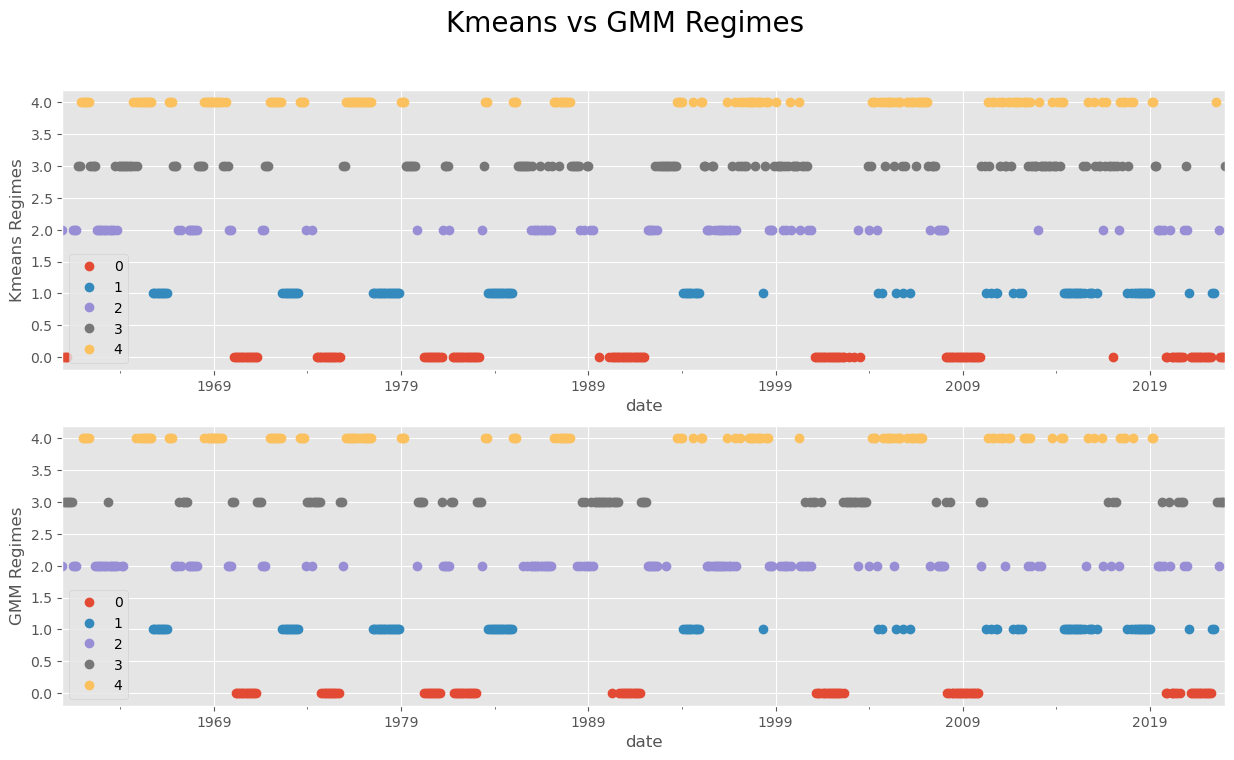

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8))

# add title
fig.suptitle("Kmeans vs GMM Regimes", fontsize=20)
kmeans_pivot_X[[v for v in range(k)]].plot(ax=axs[0], marker="o", linestyle="")
axs[0].set_xlabel("date")
axs[0].set_ylabel("Kmeans Regimes")
axs[0].legend()

gmm_pivot_X[[v for v in range(k)]].plot(ax=axs[1], marker="o", linestyle="")
axs[1].set_xlabel("date")
axs[1].set_ylabel("GMM Regimes")
axs[1].legend()

## Compare probabilities

In [24]:
knn_euc_probs_df = pd.DataFrame(knn_euc_probs, index=train.index)
gmm_euc_probs_df = pd.DataFrame(gmm_euc_probs, train.index)

knn_hard_probs_df = pd.DataFrame(knn_hard_probs, train.index)
gmm_hard_probs_df = pd.DataFrame(gmm_hard_probs, train.index)

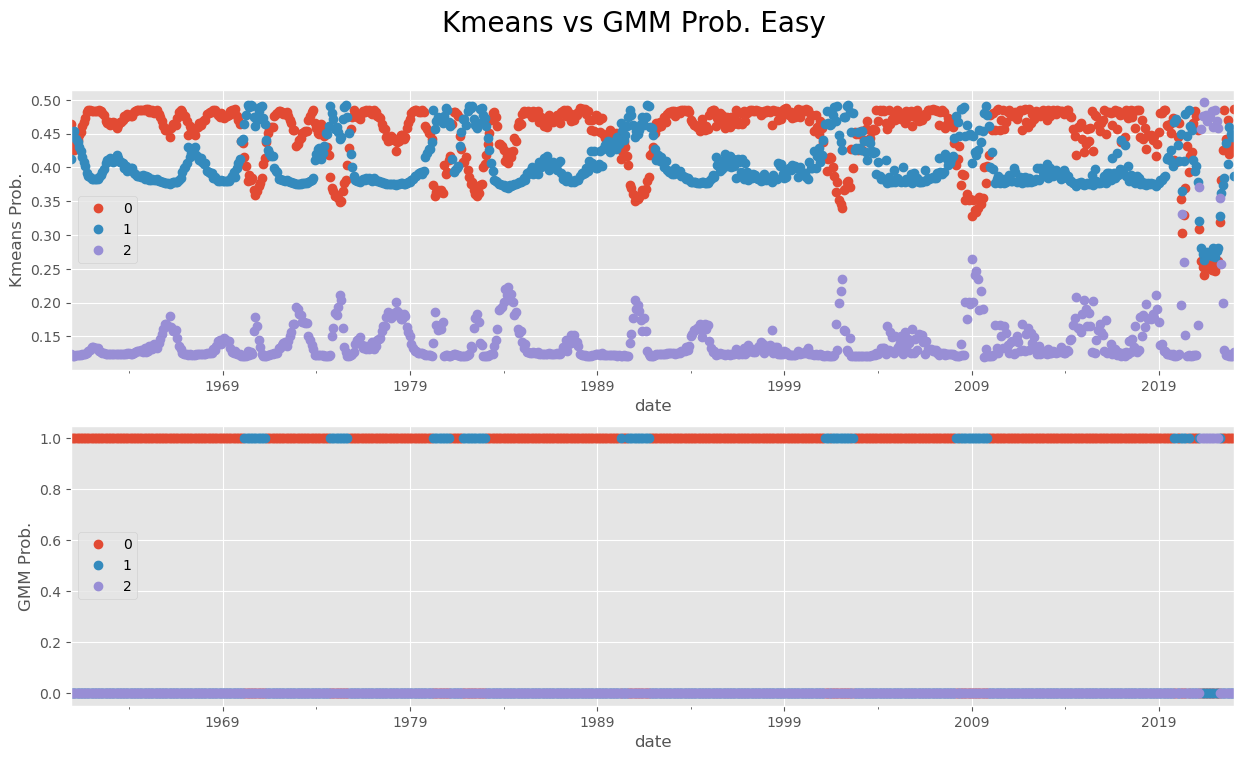

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8))

# add title
fig.suptitle("Kmeans vs GMM Prob. Easy", fontsize=20)
knn_euc_probs_df.plot(ax=axs[0], marker="o", linestyle="")
axs[0].set_xlabel("date")
axs[0].set_ylabel("Kmeans Prob.")
axs[0].legend()

gmm_euc_probs_df.plot(ax=axs[1], marker="o", linestyle="")
axs[1].set_xlabel("date")
axs[1].set_ylabel("GMM Prob.")
axs[1].legend()

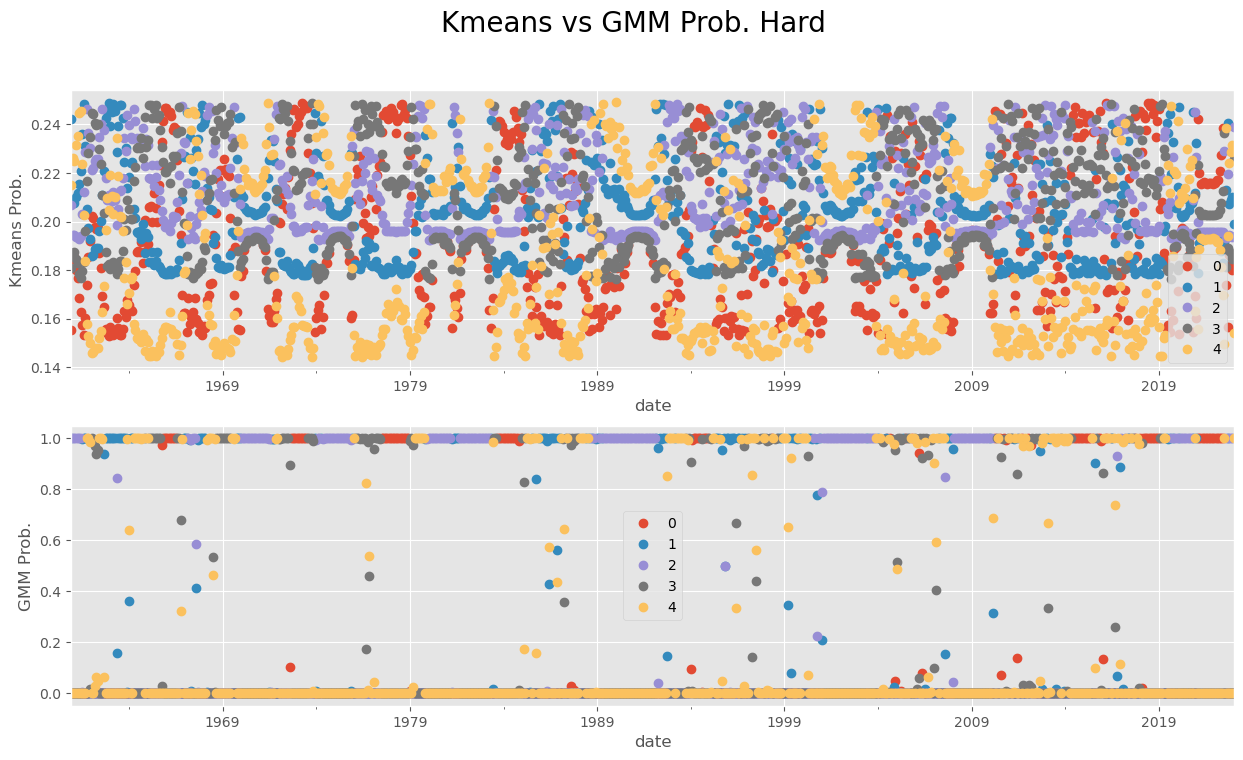

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8))

# add title
fig.suptitle("Kmeans vs GMM Prob. Hard", fontsize=20)
knn_hard_probs_df.plot(ax=axs[0], marker="o", linestyle="")
axs[0].set_xlabel("date")
axs[0].set_ylabel("Kmeans Prob.")
axs[0].legend()

gmm_hard_probs_df.plot(ax=axs[1], marker="o", linestyle="")
axs[1].set_xlabel("date")
axs[1].set_ylabel("GMM Prob.")
axs[1].legend()

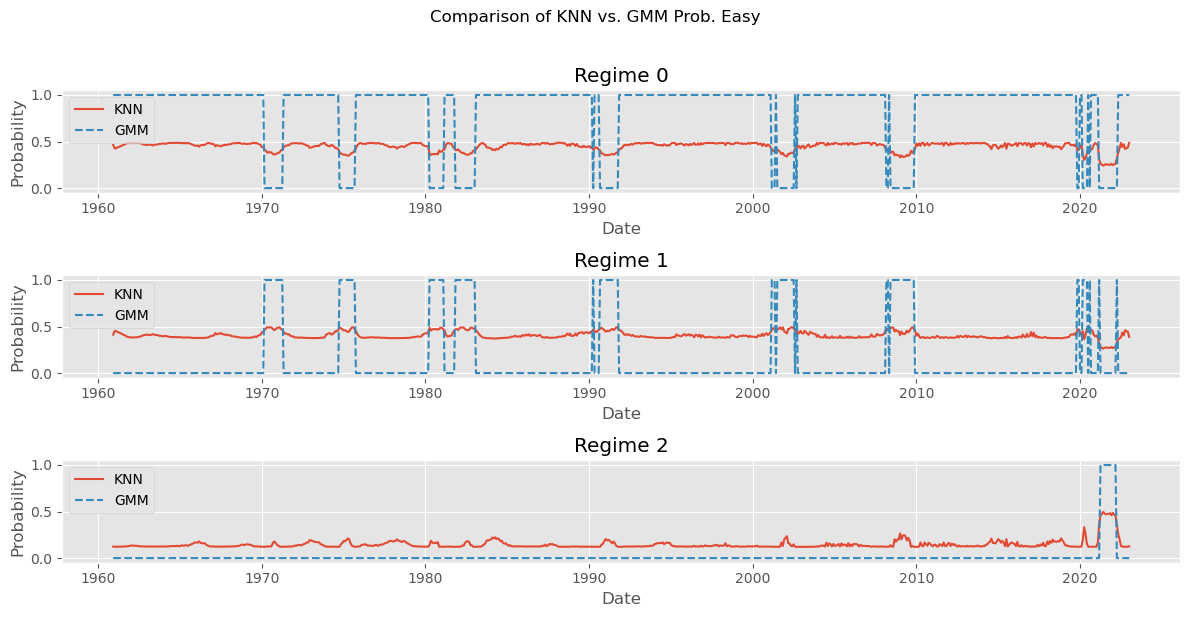

In [36]:
# Set the figure size and number of subplots for EUC probabilities comparison
fig, axes = plt.subplots(len(knn_euc_probs_df.columns), 1, figsize=(12, 2 * len(knn_euc_probs_df.columns)))
fig.suptitle("Comparison of KNN vs. GMM Prob. Easy", y=1.02)

for i, feature in enumerate(knn_euc_probs_df.columns):
    ax = axes[i]
    ax.plot(knn_euc_probs_df.index, knn_euc_probs_df[feature], label="KNN")
    ax.plot(gmm_euc_probs_df.index, gmm_euc_probs_df[feature], label="GMM", linestyle="--")
    ax.set_title(f"Regime {feature}")
    ax.legend(loc="upper left")
    ax.set_ylabel("Probability")
    ax.set_xlabel("Date")

plt.tight_layout()
plt.show()

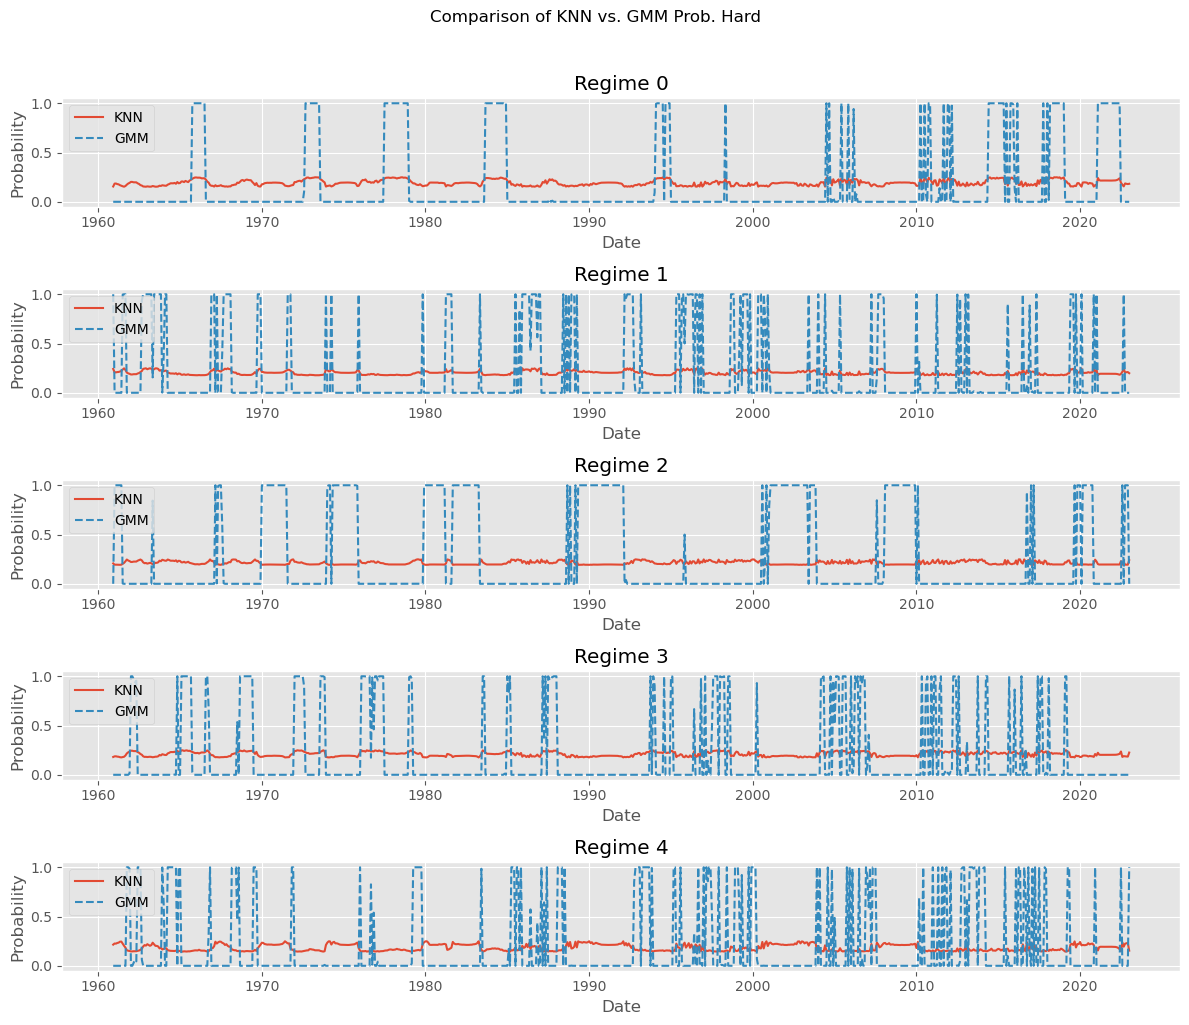

In [38]:
# Set the figure size and number of subplots for HARD probabilities comparison
fig, axes = plt.subplots(len(knn_hard_probs_df.columns), 1, figsize=(12, 2 * len(knn_hard_probs_df.columns)))
fig.suptitle("Comparison of KNN vs. GMM Prob. Hard", y=1.02)

for i, feature in enumerate(knn_hard_probs_df.columns):
    ax = axes[i]
    ax.plot(knn_hard_probs_df.index, knn_hard_probs_df[feature], label="KNN")
    ax.plot(gmm_hard_probs_df.index, gmm_hard_probs_df[feature], label="GMM", linestyle="--")
    ax.set_title(f"Regime {feature}")
    ax.legend(loc="upper left")
    ax.set_ylabel("Probability")
    ax.set_xlabel("Date")

plt.tight_layout()
plt.show()